In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import librosa 
import keras.preprocessing
import cv2
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder  

#from tensorflow.keras.utils import to_categorical #make image label categorical 
from sklearn.model_selection import train_test_split # split into datastes 

In [2]:
df = pd.read_csv("D:\\Instrument Sounds\\Beat Box Samples\\AVP_Dataset\\Image Dataset\\Audio_details.csv")
df.head()

,Mapped Audio File,Modality,Participant,Class,Waveform Array,Sample Rate (Hz),OG Duration (s),Trimmed Waveform,Trimmed Duration (s),Index
0,P15_Kick_Fixed,Fixed,P15,kd,[-0.00053592 -0.00061145 -0.00074712 ... 0.00...,22050,0.507755,[-0.00053592 -0.00061145 -0.00074712 ... -0.00...,0.278639,0
1,P15_Kick_Fixed,Fixed,P15,kd,[ 0.00015334 0.00053129 0.00067512 ... -0.00...,22050,0.132472,[ 0.00015334 0.00053129 0.00067512 ... -0.00...,0.132472,1
2,P15_Kick_Fixed,Fixed,P15,kd,[-0.00453238 -0.00441207 -0.00418556 ... -0.00...,22050,0.638549,[-0.00453238 -0.00441207 -0.00418556 ... -0.00...,0.278639,2
3,P15_Kick_Fixed,Fixed,P15,kd,[ 3.3045188e-05 1.8108636e-05 1.2554787e-04 ...,22050,0.544218,[3.3045188e-05 1.8108636e-05 1.2554787e-04 ......,0.301859,3
4,P15_Kick_Fixed,Fixed,P15,kd,[-0.00120923 -0.00235417 -0.00239738 ... -0.00...,22050,0.125170,[-0.00120923 -0.00235417 -0.00239738 ... -0.00...,0.125170,4


In [3]:
df.shape

(9864, 10)

**Remove Images with errors [White Images]**

In [4]:
df = df[df['Index'] != 502]
df = df[df['Index'] != 4922]
df = df[df['Index'] != 8042]
df = df[df['Index'] != 4849]
df = df[df['Index'] != 801]
df = df[df['Index'] != 8073]
df = df[df['Index'] != 4694]

In [5]:
df.shape

(9857, 10)

## Import Images 

#### Image Normalization 

The core idea is to make the pixel values to be between 0 and 1. If it’s already between 0 and 1 then it’s not necessary. If it’s in the range between 0 and 255, then we do the division to serve the purpose aforementioned.

Some image display functions require the pixel value to be between 0 and 1.

In [6]:
NUM_CLASSES = len(df['Class'].value_counts())
#IMAGE_SIZE = (400, 600, 3)
IMAGE_SIZE = (200, 300, 3)

def get_imgs(df, dir_, img_size, num_classes):
    raw_paths = tf.io.gfile.glob(str(dir_) + '/*')
    
    #imgs_arr = np.array([])
    imgs_arr = []
    class_label = []
    indicies = []
    for path in raw_paths:
        
        img_index = path.split('_')[-1]
        img_index = img_index.split('.')[0]
        img_index = int(img_index)
        
        if(img_index in df['Index'].values):
            
            #load and resize image
            k = keras.preprocessing.image.load_img(path, target_size= img_size)
            # make image an array and normalize
            img = keras.preprocessing.image.img_to_array(k) / 255
            imgs_arr.append(img)
            #imgs_arr = np.append(imgs_arr, img)
        
            #get class
            pic_class = df[df['Index'] == img_index]
            pic_class = pic_class['Class'].iloc[0]
            
            class_label.append(pic_class)
            
            
            #get index
            indicies.append(img_index)

        else: 
            print('Index ', img_index, ' Not found!')
            

    return imgs_arr,class_label, indicies


In [7]:
images, labels, img_indicies = get_imgs(df, 'D:\\Instrument Sounds\\Beat Box Samples\\AVP_Dataset\\Image Dataset\\Mel Spectrograms', IMAGE_SIZE, NUM_CLASSES)

Index  502  Not found!
Index  801  Not found!
Index  4694  Not found!
Index  4849  Not found!
Index  4922  Not found!
Index  8042  Not found!
Index  8073  Not found!


In [8]:
np.unique(labels)

array(['hhc', 'hho', 'kd', 'sd'], dtype='<U3')

In [9]:
type(images[0])

numpy.ndarray

## Split Data Sets

In [10]:
#get training and testing sets 
x_train, x_test, y_train, y_test = train_test_split(images, labels, stratify=labels, test_size=0.2, random_state=47)

#make y's into numerical, categorical var
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

**I'm deleting the images df to free memory**

In [11]:
x_train = np.array(x_train)
x_test = np.array(x_test)

## Build - Model 1

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 149, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 147, 128)      36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 73, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 71, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 35, 128)     

## Test - Model 1

In [13]:
#set up callback to stop training when highest val accuarcy is achieved
epoch_acc_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

#set up stop checkpoint to make sure we save the best model 
model_filePath = "D:\\Instrument Sounds\\Beat Box Samples\\AVP_Dataset\Model\\BB_Model_Best.keras"
best_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_filePath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist = model.fit(x_train, y_train_encoded, validation_data=(x_test, y_test_encoded), batch_size=10, epochs=10, callbacks = [epoch_acc_callback,best_model_checkpoint])

Epoch 1/10


789/789 [==============================] - 456s 574ms/step - loss: 0.7388 - accuracy: 0.7195 - val_loss: 0.6618 - val_accuracy: 0.7348
Epoch 2/10
789/789 [==============================] - 454s 575ms/step - loss: 0.4797 - accuracy: 0.8145 - val_loss: 0.4167 - val_accuracy: 0.8448
Epoch 3/10
789/789 [==============================] - 440s 557ms/step - loss: 0.3440 - accuracy: 0.8704 - val_loss: 0.4841 - val_accuracy: 0.8382
Epoch 4/10
789/789 [==============================] - 450s 570ms/step - loss: 0.2400 - accuracy: 0.9152 - val_loss: 0.3350 - val_accuracy: 0.8879
Epoch 5/10
789/789 [==============================] - 452s 573ms/step - loss: 0.1628 - accuracy: 0.9438 - val_loss: 0.2772 - val_accuracy: 0.9123
Epoch 6/10
789/789 [==============================] - 439s 557ms/step - loss: 0.1189 - accuracy: 0.9571 - val_loss: 0.2821 - val_accuracy: 0.9113
Epoch 7/10
789/789 [==============================] - 453s 574ms/step - loss: 0.0857 - accuracy: 0.9682 - val_loss: 0.3587

## Validation Results - Model 1

[]

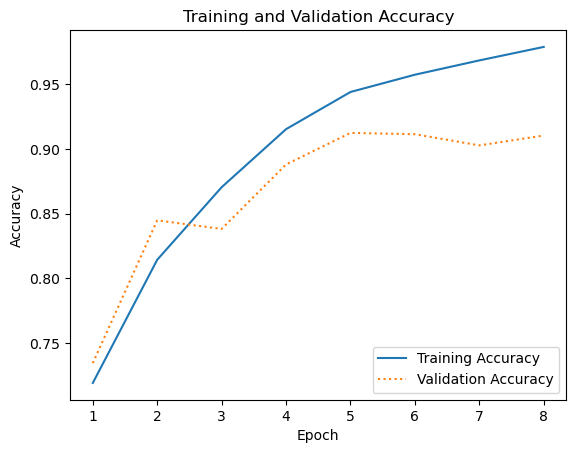

In [14]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [15]:
#hist.model.save("D:\\Instrument Sounds\\Beat Box Samples\\AVP_Dataset\Model\\BB_Model_Best.keras")

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = hist.model.predict(x_test)

62/62 [==============================] - 25s 399ms/step


In [17]:
#return max index (max index == predicted class)
def encode_y_test(predicted_y):
    y_predicted_encoded = []
    for i in range(len(predicted_y)):
        y_predicted_encoded.append(predicted_y[i].argmax())
    return np.array(y_predicted_encoded)

**y_predicted gives the probability of a class**

**Todo: make a test set with clips of my own and stuff from YouTube**

Text(110.44999999999997, 0.5, 'Actual label')

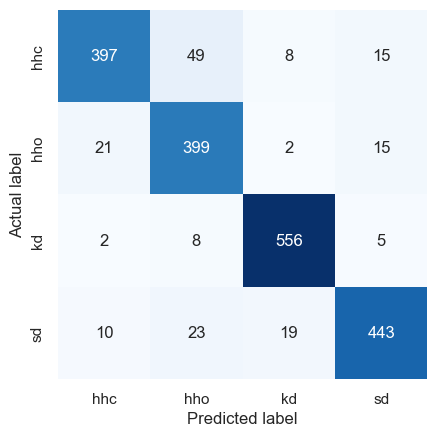

In [18]:
mat = confusion_matrix(y_test_encoded, encode_y_test(y_predicted))
class_labels = list(np.unique(labels))

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')